## **1. Prepareation**

### 1.1 Libraries Used:
- `tqdm`: For progress bars.
- `numpy`, `pandas`: For data manipulation.
- `matplotlib.pyplot`: For visualization (not used in this block but will be useful later).
- `scipy.optimize.curve_fit`: For curve fitting in trend analysis.
- `sklearn.linear_model.LinearRegression`: For applying linear regression (used later).

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

### 1.2 `prepare_data()` Function:
1. Reads Bitcoin historical data from CoinMetrics' public GitHub CSV, which provides **up-to-date, free, high-quality data** on Bitcoin's market metrics.
2. Removes the first two years of data (`data[365*2:-1]`) to **exclude early price movements**.
3. Converts the `'time'` column to a **datetime format** and sets it as the index.
4. Computes the **logarithm of the price** (`LogPriceUSD`) for trend analysis.
5. Selects only the relevant columns: `'PriceUSD'` and `'LogPriceUSD'`.
6. Fills missing values with zero (`fillna(0)`) to avoid errors in calculations.

In [11]:
def prepare_data():
    
    data = pd.read_csv('https://raw.githubusercontent.com/coinmetrics/data/refs/heads/master/csv/btc.csv')
    data = data[365*2:-1]

    data['Date'] = pd.to_datetime(data['time'])
    data.set_index('Date', inplace=True)
    
    data['LogPriceUSD'] = np.log(data['PriceUSD'])
    data = data[['PriceUSD', 'LogPriceUSD']]
    data.fillna(0, inplace=True)
    
    return data

data = prepare_data()

C:\Users\marcc\AppData\Local\Temp\ipykernel_20780\3919526007.py:3: DtypeWarning: Columns (147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('https://raw.githubusercontent.com/coinmetrics/data/refs/heads/master/csv/btc.csv')


## **2. Transformation**

### 2.1 Logarithmic Trend Extraction ###

Given an observation <code>Y<sub>t</sub></code>, we approximate its underlying trend using a logarithmic function of the form: 

**Y<sub>t</sub> = a + b * log(X<sub>t</sub> + c)**

where <code>X<sub>t</sub></code> represents the time index transformed into an integer format, and <code>(a, b, c)</code> are estimated via non-linear least squares fitting. This transformation is particularly effective in capturing **exponential-like growth** while ensuring numerical stability in cases of small <code>X<sub>t</sub></code>.  

In [12]:
def log_fit(x, a, b, c):
    
    return a * np.log(x + c) + b


def log_trend(X, Y, get_param=False):
    """
    X : array-like, a series of date indices in integer form.
    Y : array-like, a series of float values corresponding to the dependent variable.
        
    get_param : bool, optional
        If `get_param` is False, returns an array of fitted trend values.
        If `get_param` is True, returns a tuple `(a, b, c)`, which are the parameters of the logarithmic trend.
    """
    
    initial_guess = [1, 1, 1]
    fitted_param, _ = curve_fit(log_fit, X, Y, p0=initial_guess)
    a, b, c = fitted_param
    
    trend = log_fit(X, a, b, c)
    if get_param: return a, b, c
    else: return trend

### 2.2 Residual Scaling
After estimating the log trend <code>Ŷ<sub>t</sub></code>, the residual component is obtained as:

**R<sub>t</sub> = Y<sub>t</sub> - Ŷ<sub>t</sub>**

After the residual component is obtained, we proceed to:
- Computes **rolling volatility** (30-day standard deviation of residuals).
- Fits a **linear regression** to model volatility over time.

Normalized scaled residual is obtained as:
  
**Ř<sub>t</sub> = R<sub>t</sub> / Volatility Trend**

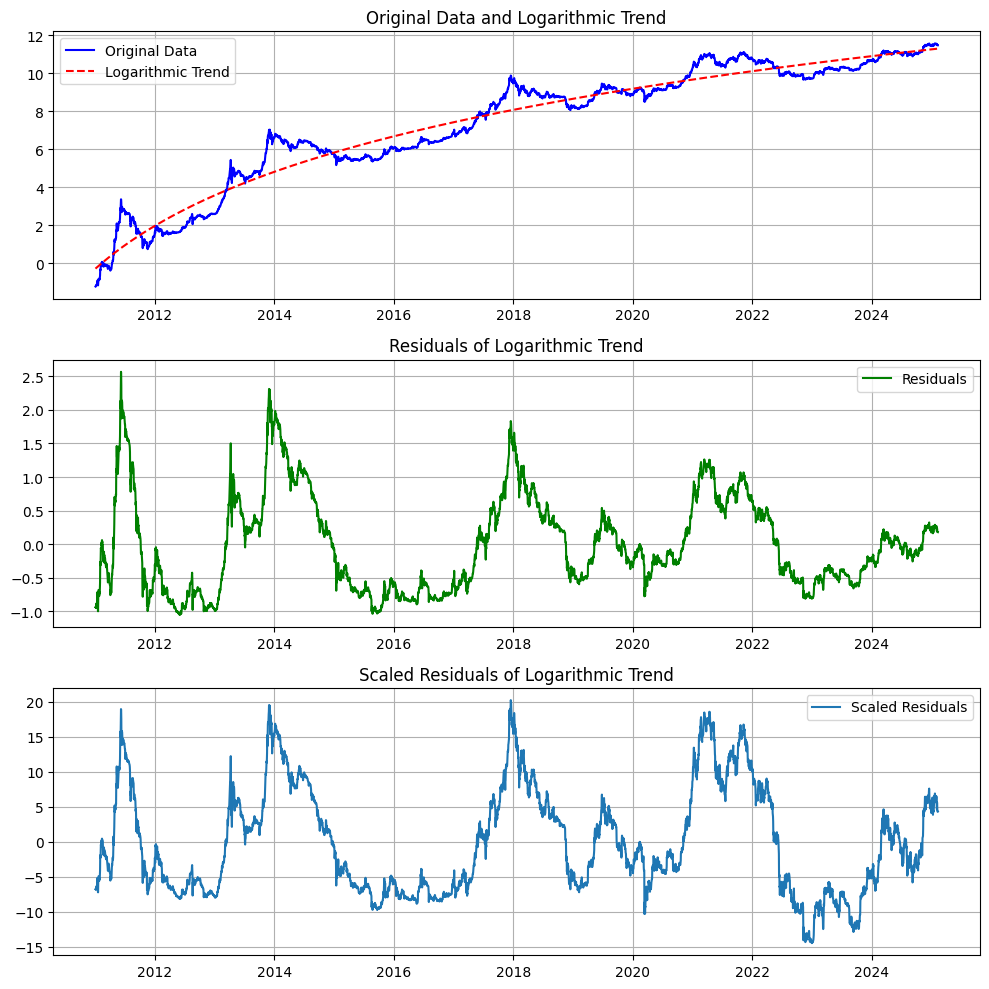

In [13]:
def transform_col(df, name, plot=False):
        
    # 1. Logarithmic Transform    
    Y = pd.Series(df[f'{name}']) 
    X = (Y.index - Y.index[0]).days

    df[f'{name}_log_trend'] = log_trend(X, Y, get_param=False)
    df[f'{name}_residuals'] = df[f'{name}'] - df[f'{name}_log_trend']
    
    # 2. Residual Scaling    
    rolling_window=30
    volatility = df[f'{name}_residuals'].rolling(rolling_window).std().dropna()

    Y = volatility.values.reshape(-1, 1)
    X = np.arange(len(volatility)).reshape(-1, 1)  # Time as feature

    def get_vol_trend(X, Y):
        
        regressor = LinearRegression()
        regressor.fit(X, Y)        
        trend = regressor.predict(np.arange(len(df)).reshape(-1, 1))
        return trend

    df[f'{name}_vol_trend'] = get_vol_trend(X, Y)
    df[f'{name}_scaled_residuals'] = df[f'{name}_residuals'] / df[f'{name}_vol_trend']

    # 3. Plotting
    def plot_trend_residuals(df):
        
        fig, axs = plt.subplots(3, 1, figsize=(10, 10))

        axs[0].set_title("Original Data and Logarithmic Trend")
        axs[1].set_title("Residuals of Logarithmic Trend")
        axs[2].set_title('Scaled Residuals of Logarithmic Trend')

        axs[0].plot(df.index, df[f'{name}'], label='Original Data', color='blue')
        axs[0].plot(df.index, df[f'{name}_log_trend'], label='Logarithmic Trend', color='red', linestyle='--')
        axs[1].plot(df.index, df[f'{name}_residuals'], label='Residuals', color='green')
        axs[2].plot(df.index, df[f'{name}_scaled_residuals'], label='Scaled Residuals')
        
        [ax.grid(True) or ax.legend() for ax in axs]
        
        plt.tight_layout()
        plt.show()

    if plot: plot_trend_residuals(df)
    return df

data = transform_col(data, 'LogPriceUSD', plot=True)

### 2.3 Signal Generation

This function generates **buy** and **sell** signals based on extreme deviations in **scaled residuals**, which helps identify potential overbought or oversold conditions.

Buy & Sell Conditions:
- **Buy Signal**: When `LogPriceUSD_scaled_residuals < -5`, indicating a strong downward deviation from the trend.
- **Sell Signal**: When `LogPriceUSD_scaled_residuals > 10`, indicating a strong upward deviation from the trend.

In [14]:
def generate_signals(df):
    
    df = df.copy()
    df["Signal"] = "Empty"
    df.loc[df["LogPriceUSD_scaled_residuals"] < -5, "Signal"] = "Buy"  # Buy signal
    df.loc[df["LogPriceUSD_scaled_residuals"] > 10, "Signal"] = "Sell"  # Sell signal
    return df

data = generate_signals(data)

## **3. Strategy Backtest**

### 3.1 HODL Strategy
This strategy assumes an investor **buys Bitcoin at the first available price and holds it** until the last date.

#### Why Use HODL?
- Simple and requires no active management.
- Served as a baseline for our testing.

In [15]:
def HODL_strategy(df, initial_capital):
    
    first_price = df.iloc[0]['PriceUSD']
    btc_held = initial_capital / first_price  
    final_value = btc_held * df.iloc[-1]['PriceUSD']  
    
    equity_curve = [btc_held * price for price in df['PriceUSD']]  
    output = df.copy()
    output.loc[:, 'Equity'] = equity_curve

    return output, final_value

df_HODL, final_value_HODL = HODL_strategy(df=data[-9*365:], initial_capital=10000)

### 3.2 DCA Strategy
This strategy **systematically buys and sells** Bitcoin based on generated signals (`Buy` and `Sell`).  
However, unlike traditional linear DCA, this implementation executes a large portion of capital based on an exponential allocation model.

- At each buy/sell signal, only a small percentage (for example 5%) of the remaining capital/equity is invested/sold.
- The remaining capital **shrinks exponentially** after each buy: **Capital<sub> t</sub> = Capital<sub> 0</sub> * 0.95<sup>t</sup>**
- The remaining equity **shrinks exponentially** after each sell: **Equity<sub> t</sub> = Equity<sub> 0</sub> * 0.95<sup>t</sup>**

This helps secure profits quickly rather than slowly scaling out, and ensures more capital is put to work during market dips.

In [16]:
def DCA_strategy(df, initial_capital, allocation_per_trade):
    
    capital = 0  
    position =  initial_capital / df.iloc[0]['PriceUSD']
    equity_curve = []  
    trade_history = []
    
    for i in range(len(df)):
        price = df.iloc[i]['PriceUSD']
        signal = df.iloc[i]['Signal']
        equity = capital + (position * price)

        if signal == 'Buy' and capital > 0:
            amount_to_invest = capital * allocation_per_trade
            btc_to_buy = amount_to_invest / price
            
            if btc_to_buy > 0:
                position += btc_to_buy
                capital -= amount_to_invest  
                trade_history.append({'Type': 'Buy', 'Price': price, 'BTC': btc_to_buy, 'Capital': capital})

        elif signal == 'Sell' and position > 0:
            btc_to_sell = position * allocation_per_trade
            
            if btc_to_sell > 0:
                capital += btc_to_sell * price  
                position -= btc_to_sell  
                trade_history.append({'Type': 'Sell', 'Price': price, 'BTC': btc_to_sell, 'Capital': capital})

        equity_curve.append(equity)  
        
    output = df.copy()
    output.loc[:, 'Equity'] = equity_curve
    final_value = capital + (position * df.iloc[-1]['PriceUSD'])
    
    return output, trade_history, final_value

df_DCA, trade_history, final_value_DCA = DCA_strategy(df=data[-9*365:], initial_capital=10000, allocation_per_trade=0.025)

### 3️.3 Allocation Optimization
Finds the **best allocation per trade** for DCA over different timeframes.

1. Loops over **backtest periods** from **4 to 11 years**.
2. Iterates through allocation percentages **1% to 99%**.
3. Runs `DCA_strategy()` for each combination.

The best allocation per trade is around **2% to 3%**.

In [17]:
def optimize_allocation(df):
    
    dct = {}
    for year in range(4, 12):
        all_final_values = []
        for i in tqdm(range(1, 100)):
            _, _, final_value = DCA_strategy(df=data[-year*365:], initial_capital=10000, allocation_per_trade=i/100)
            all_final_values.append(final_value)
        dct[f'{year} years'] = all_final_values.copy()
    return dct

# dct = optimize_allocation(df)

## **4. Result**

### 4.1 Plotting Strategy Results: Buy & Hold vs. DCA

#### Equity Curve Comparison
- If **`log=True`**, it shows the **logarithmic scale** of the portfolio values, helping to observe **percentage changes** rather than absolute values.
- If **`log=False`**, the plot displays **absolute portfolio values** (in dollars).

#### BTC Price with Buy/Sell Signals
- This plot shows the historical Bitcoin price with overlaid **buy** and **sell** signals.
- **Buy signals** are marked as green squares, and **sell signals** as red squares

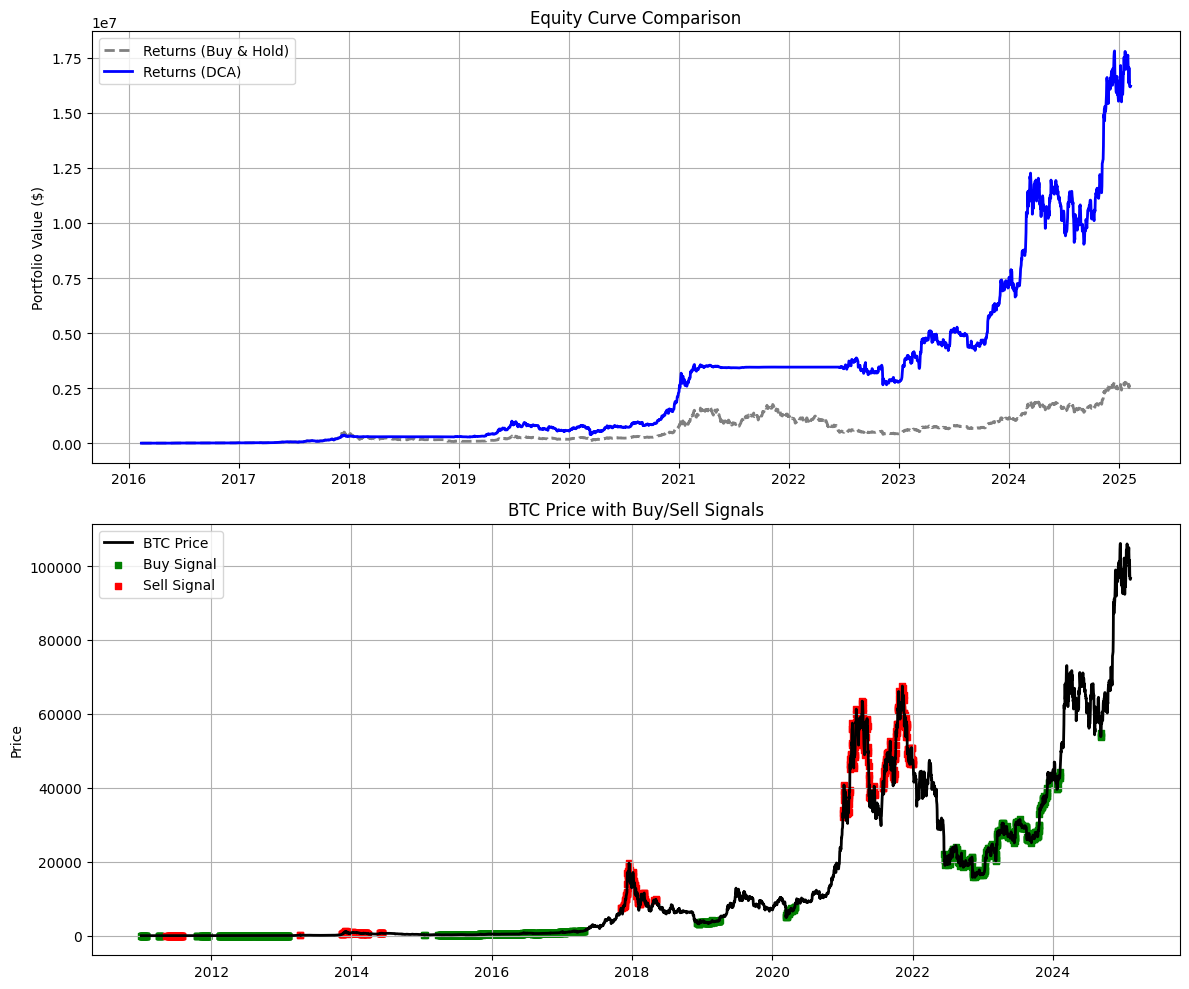

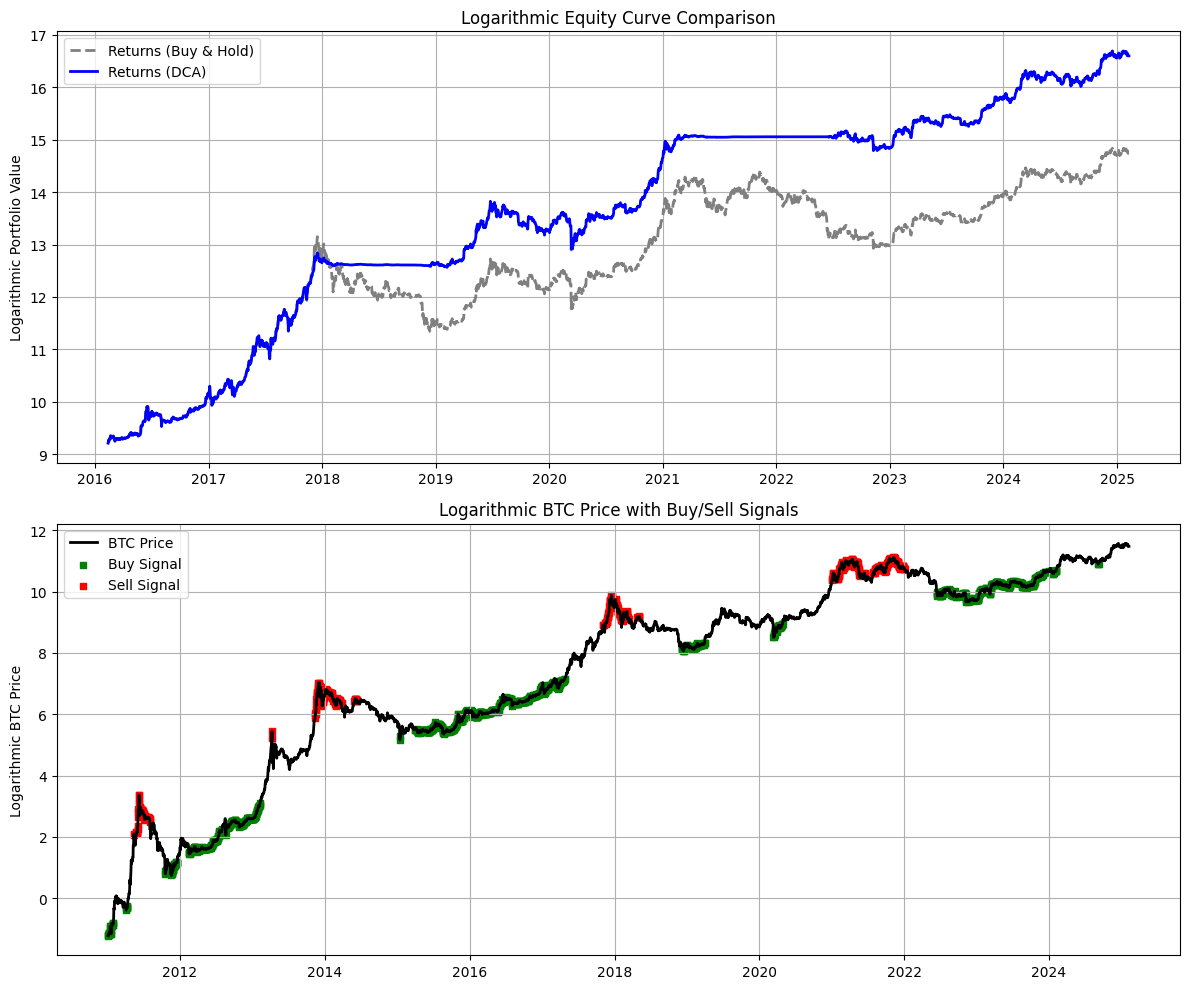

In [18]:
def plot_results(df, df_HODL, df_DCA, log=False):
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Equity Curves
    if log:
        axs[0].plot(df_HODL.index, np.log(df_HODL['Equity']), label='Returns (Buy & Hold)', color='gray', linestyle='dashed', linewidth=2)
        axs[0].plot(df_DCA.index, np.log(df_DCA['Equity']), label='Returns (DCA)', color='blue', linewidth=2)
        axs[0].set_title('Logarithmic Equity Curve Comparison')
        axs[0].set_ylabel('Logarithmic Portfolio Value')
    else:
        axs[0].plot(df_HODL.index, df_HODL['Equity'], label='Returns (Buy & Hold)', color='gray', linestyle='dashed', linewidth=2)
        axs[0].plot(df_DCA.index, df_DCA['Equity'], label='Returns (DCA)', color='blue', linewidth=2)
        axs[0].set_title('Equity Curve Comparison')
        axs[0].set_ylabel('Portfolio Value ($)')

    # Plot 2: BTC Price with Buy/Sell Signals
    buy_signals = df[df['Signal'] == 'Buy']
    sell_signals = df[df['Signal'] == 'Sell']
    
    if log:
        axs[1].plot(df.index, np.log(df['PriceUSD']), label='BTC Price', color='black', linewidth=2)
        axs[1].scatter(buy_signals.index, np.log(buy_signals['PriceUSD']), label='Buy Signal', color='green', marker='s', s=25)
        axs[1].scatter(sell_signals.index, np.log(sell_signals['PriceUSD']), label='Sell Signal', color='red', marker='s', s=25)
        axs[1].set_title('Logarithmic BTC Price with Buy/Sell Signals')
        axs[1].set_ylabel('Logarithmic BTC Price')
    else:
        axs[1].plot(df.index, df['PriceUSD'], label='BTC Price', color='black', linewidth=2)
        axs[1].scatter(buy_signals.index, buy_signals['PriceUSD'], label='Buy Signal', color='green', marker='s', s=25)
        axs[1].scatter(sell_signals.index, sell_signals['PriceUSD'], label='Sell Signal', color='red', marker='s', s=25)
        axs[1].set_title('BTC Price with Buy/Sell Signals')
        axs[1].set_ylabel('Price')

    [ax.grid(True) or ax.legend() for ax in axs]
    
    plt.tight_layout()
    plt.show()


plot_results(data, df_HODL, df_DCA)
plot_results(data, df_HODL, df_DCA, log=True)

### 4.2 Performance Comparison: DCA vs. Buy & Hold (HODL)

As shown in the graph, the **DCA strategy** significantly outperforms the **Buy & Hold (HODL) strategy**. Over the same period, the DCA strategy has achieved **almost 700% greater returns** than HODL.

- **HODL Strategy**: While it benefits from long-term price appreciation, its performance is somewhat limited by market downturns, where it does not adjust its position based on market signals.
  
- **DCA Strategy**: The DCA strategy, by buying consistently at lower prices and scaling out at higher prices, captures more gains during market corrections and periods of volatility. This **dynamic approach** allows for **better capital allocation**, which contributes to its higher returns.

The DCA strategy not only mitigates risks but also maximizes returns by **timing the market better** using buy and sell signals. The **700% increase** in performance is a testament to the power of **systematic, timed investments** compared to a simple buy-and-hold approach.